# Results of experiments
- compare interpretations of EBM, GAMI-Net, maybe SNAM (hard to compare)
- plot shape functions
- plot variable importances (for SNAM, it could be only which ones were selected)

In [60]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['lines.color']='k'
mpl.rcParams['lines.linestyle']='solid'

%matplotlib inline
mpl.style.use('seaborn')

import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from src.gaminet.utils import feature_importance_visualize
from src.ebm.plot import plot_shape_function
from src.plot_all import ebm_plot_all
from src.ebm.train import load_pickled_object, save_pickled_object

In [40]:
### load interpreation data
ebm_dir = 'models/ebm/'
gaminet_dir = 'models/gaminet/'
figure_dir = 'figures/results/'

feature_names = load_pickled_object(f'{ebm_dir}feature_names_all.pkl')

# load raw data from ebm, gaminet, snam, i.e. feature importances, shape functions

shape_data_ebm = load_pickled_object(f'{ebm_dir}146_shape_data.pkl')

feature_importance_ebm = pd.read_pickle(f'{ebm_dir}146_feature_importance_df.pkl')

explain_data_gaminet = np.load(f'{gaminet_dir}147_global_explain.npy', allow_pickle=True)
explain_data_gaminet = explain_data_gaminet[()]

## Shape functions

### EBM

issue: has to separate individual and pairwise effects 

univariate


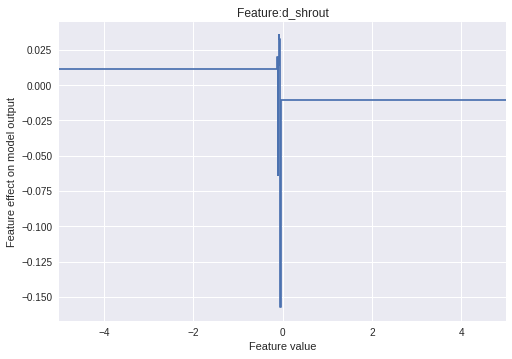

univariate


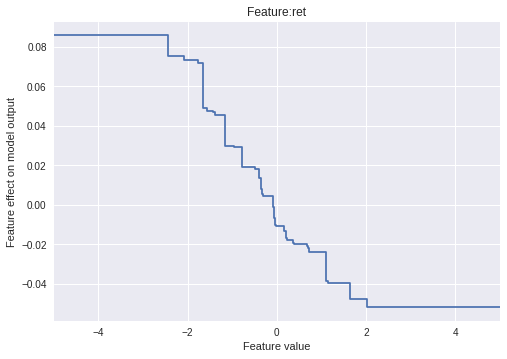

bivariate
bivariate
bivariate
univariate


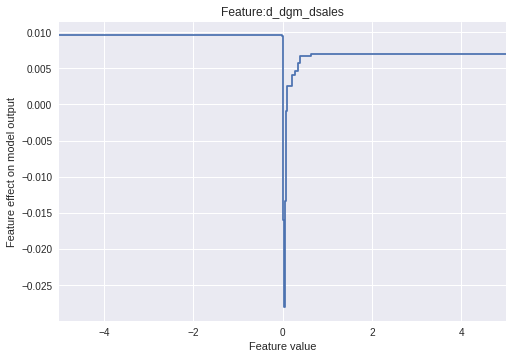

univariate


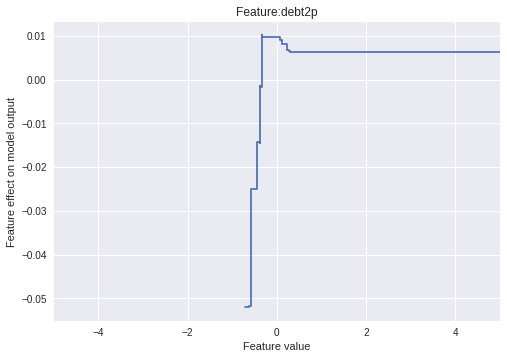

bivariate
univariate


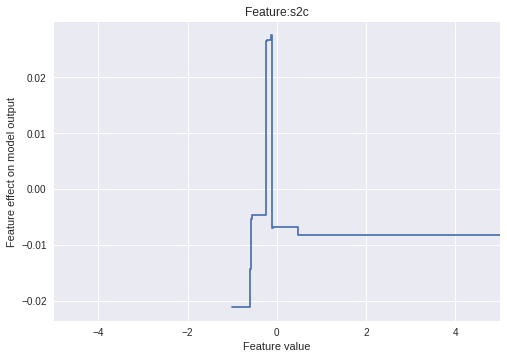

univariate


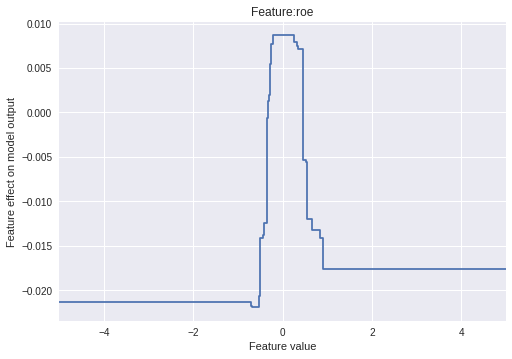

univariate


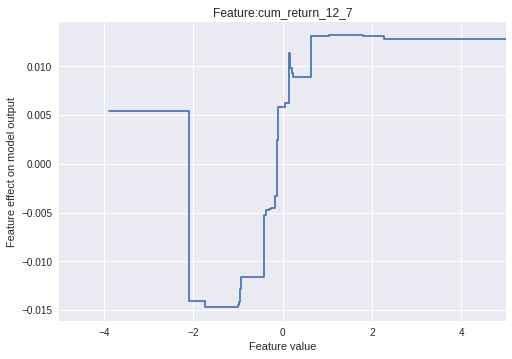

bivariate
univariate


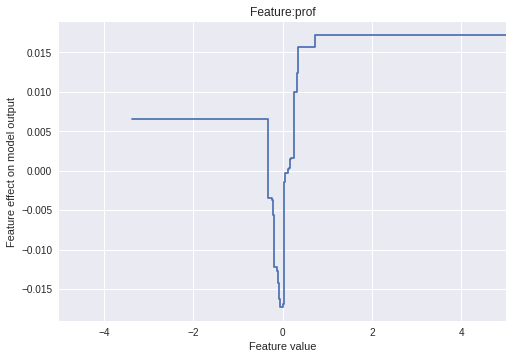

univariate


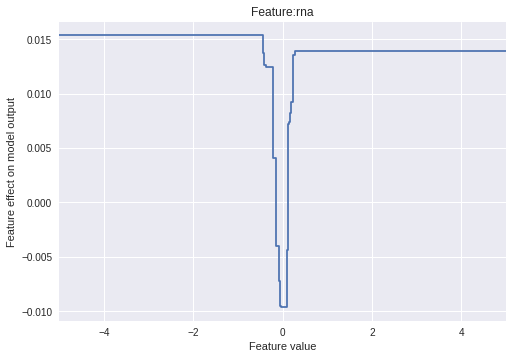

bivariate
bivariate
univariate


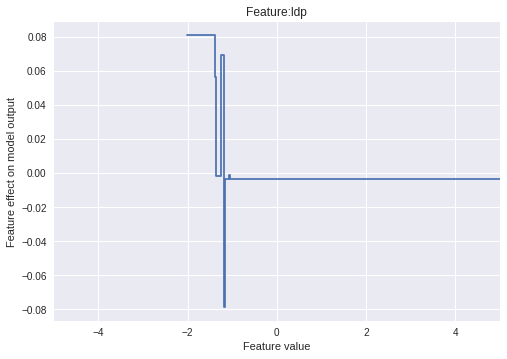

univariate


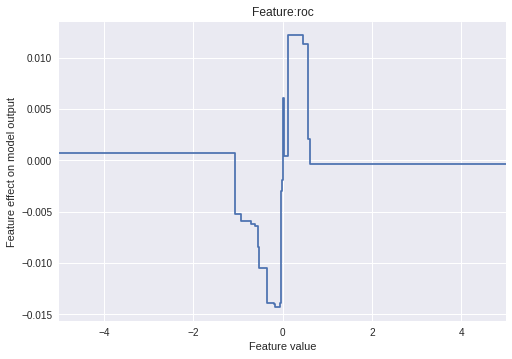

univariate


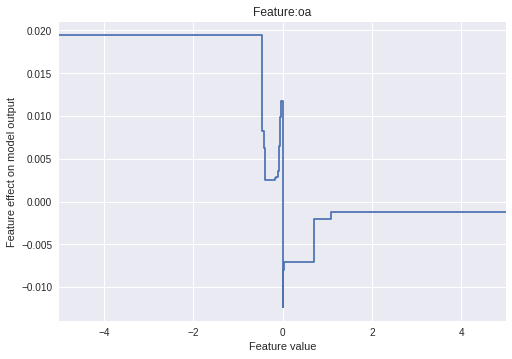

bivariate
univariate


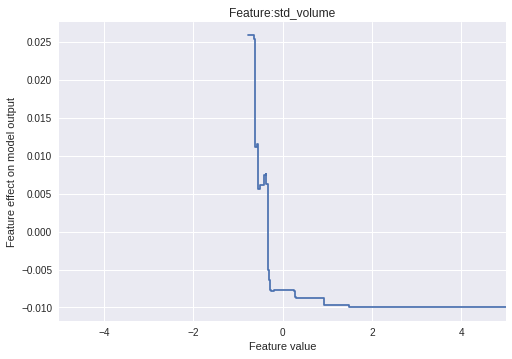

In [3]:
# sort feat importance
feature_importance_ebm = feature_importance_ebm.sort_values(by='importance score', ascending=False)

# change col type -> bivariate
for idx, row in feature_importance_ebm.iterrows():
    #feature_importance_ebm = feature_importance_ebm.copy()
    if ' x ' in row.feature:
        feature_importance_ebm.at[idx, 'type'] = 'bivariate'
        
# save feature indices by importance -> query shape data dict
importance_sorted_idx_ebm = feature_importance_ebm.index
importance_sorted_idx_ebm_top_20 = importance_sorted_idx_ebm[:21]

# save feature names of top 20 effects -> both main effects and interactions (effects)
effect_names = feature_importance_ebm['feature'].values
effect_names_top_20 = effect_names[0:21]

# # setup variables to query shape data
# single_feature_idx = importance_idx_ebm[query_id]
# single_feature_name = effect_names[query_id]

# # query data
#single_feature_shape_data = shape_data_ebm[single_feature_idx]

# plot top 20 effects:
i=0
for fid in importance_sorted_idx_ebm_top_20:
    single_feature_shape_data = shape_data_ebm[fid]
    if single_feature_shape_data['type']=='interaction':
        print('bivariate')
        pass # to-do
    else:
        #single_feature_shape_data = shape_data_ebm[fid]
        single_feature_name = effect_names[i]
        print('univariate')
        plot_shape_function(single_feature_shape_data, single_feature_name, "full", "146")
    i += 1

# plot shape function
#plot_shape_function(single_feature_shape_data, single_feature_name, "", "")

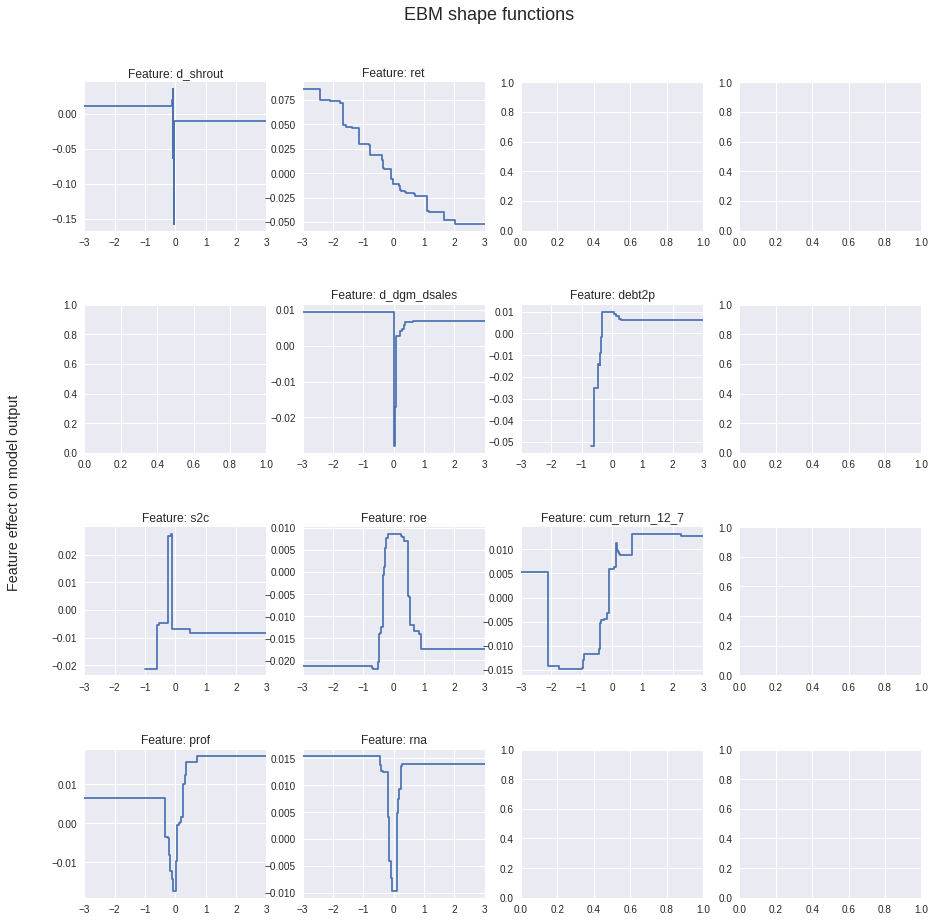

In [28]:
### Plot all effects in one subplot!
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("EBM shape functions", fontsize=18, y=0.95)
fig.text(0.06, 0.5, 'Feature effect on model output', ha='center', va='center', rotation='vertical', fontsize='x-large')

# loop through ids and axes
i=0 

for fid, ax in zip(importance_sorted_idx_ebm_top_20, axs.ravel()):
    
    # define the shape function data and feature name for every fid
    single_feature_shape_data = shape_data_ebm[fid]
    single_feature_name = effect_names[i]
    
    if single_feature_shape_data['type']=='interaction':
        #print('bivariate')
        pass # to-do
    
    else:
        
        x_vals = single_feature_shape_data["names"].copy()
        y_vals = single_feature_shape_data["scores"].copy()

        # prepare data
        y_vals = np.r_[y_vals, y_vals[np.newaxis, -1]] 
        x = np.array(x_vals)
        
        # plot
        ax.set_xlim(left=-3, right=3)
        ax.step(x, y_vals, where="post")
        
        ax.set_xlabel(f'Feature value')
        ax.set_title(f'Feature: {single_feature_name}')
        
        #plot_shape_function(single_feature_shape_data, single_feature_name, "full", "146")
    i += 1

    # chart formatting
    #ax.set_title(ticker.upper())
    #ax.get_legend().remove()
    ax.set_xlabel("")
fig.savefig(f'{figure_dir}ebm_shapes_all_00.png')
plt.show()


In [ ]:
#plot_shape_function(shape_data_ebm[0]['scores'], feature_name=feature_names, num_cols=num_cols, scaler_dict={})

## Plot importances
- use gaminet util-function
- takes `data_dict` as input that needs feature names as keys and `importance` as values

In [41]:
explain_data_gaminet['d_so']

{'density': {'names': array([-0.60149966, -0.4123622 , -0.22322474, -0.03408729,  0.15505017,
          0.34418763,  0.53332508,  0.72246254,  0.9116    ,  1.10073745,
          1.28987491]),
  'scores': array([7.61924620e-05, 6.34937183e-04, 7.26368138e-03, 3.43674989e+00,
         1.79998342e+00, 3.76898712e-02, 3.02230099e-03, 1.16828442e-03,
         3.17468592e-04, 2.53974873e-04])},
 'type': 'continuous',
 'importance': 0.000966396984129836,
 'inputs': array([-1.01395512, -0.95952978, -0.90510443, -0.85067909, -0.79625374,
        -0.7418284 , -0.68740305, -0.63297771, -0.57855236, -0.52412702,
        -0.46970168, -0.41527633, -0.36085099, -0.30642564, -0.2520003 ,
        -0.19757495, -0.14314961, -0.08872426, -0.03429892,  0.02012643,
         0.07455177,  0.12897712,  0.18340246,  0.23782781,  0.29225315,
         0.34667849,  0.40110384,  0.45552918,  0.50995453,  0.56437987,
         0.61880522,  0.67323056,  0.72765591,  0.78208125,  0.8365066 ,
         0.89093194,  0.945

In [56]:
#importance_data_ebm = {}
keys = feature_importance_ebm.feature.to_list()
values = feature_importance_ebm['importance score']

# assign feat names as keys
for i in keys:
    importance_data_ebm[i] = {} 

# assign importance as key value pair 
for key, value in zip(importance_data_ebm, values):
    importance_data_ebm[key] = {'importance': value}

print(importance_data_ebm)

{'d_shrout x rel_to_high_price': {'importance': 0.0023509675112640075}, 'cum_return_1_0': {'importance': 0.003403907213203228}, 'cum_return_6_2': {'importance': 0.007830357106035055}, 'cum_return_12_2': {'importance': 0.010027968566773645}, 'cum_return_12_7': {'importance': 0.002230848710538934}, 'cum_return_36_13': {'importance': 0.002975844340239862}, 'investment': {'importance': 0.005129192026043212}, 'd_ceq': {'importance': 0.003738539640529804}, 'dpi2a': {'importance': 0.02809793962717277}, 'd_shrout': {'importance': 0.002854344854506805}, 'ivc': {'importance': 0.0016604616880973224}, 'noa': {'importance': 0.003640210291429958}, 'ato': {'importance': 0.0015702945354148419}, 'cto': {'importance': 0.01189960834912095}, 'd_dgm_dsales': {'importance': 0.004316364529297186}, 'eps': {'importance': 0.003059029604152963}, 'ipm': {'importance': 0.003149941974453019}, 'pcm': {'importance': 0.002820118357072353}, 'pm': {'importance': 0.00763135445057304}, 'pm_adj': {'importance': 0.009600167

In [64]:
ebm_importance_dict_top_20 = dict(list(importance_data_ebm.items())[:21])

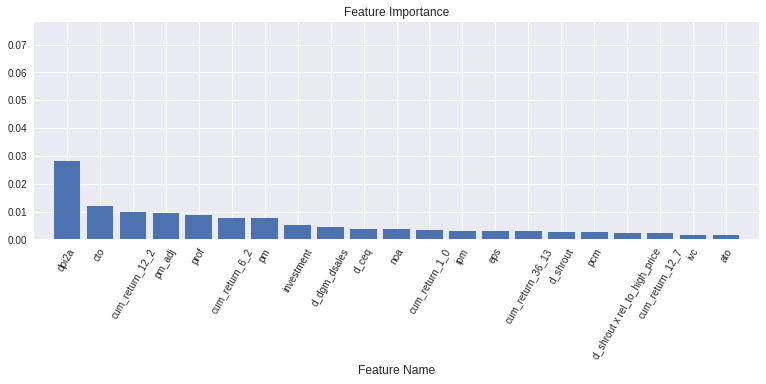

In [65]:
# plot top 20 shape functions ordered by importance
# TO-DO: plot ebm functions by importance (how?)
ebm_importance_data = importance_data_ebm

feature_importance_visualize(ebm_importance_dict_top_20, folder="./results/", name="demo", save_png=False, save_eps=False)